In [1]:
import numpy as np
import minterpy as mp
from minterpy.extras.regression import *
from matplotlib import pyplot as plt

import torch
import torchvision
from torchvision import transforms, datasets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.neighbors import NearestNeighbors

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

from matplotlib.colors import Normalize

In [2]:
def getFashionMNIST(batch_size = 10):
    fashionmnist_data = torchvision.datasets.FashionMNIST(download=True, root = 'data/fashionmnist', transform = 
                                                                                 transforms.Compose([transforms.Resize(32),
                                                                                 transforms.ToTensor(), 
                                                                                 transforms.Lambda(lambda x: x.repeat(1, 1, 1))
                                                                                 ]))

    fashionmnist_data_test = torchvision.datasets.FashionMNIST(download=True, root = 'data/fashionmnist', train=False, transform = 
                                                                                 transforms.Compose([transforms.Resize(32),
                                                                                 transforms.ToTensor(), 
                                                                                 transforms.Lambda(lambda x: x.repeat(1, 1, 1))
                                                                                 ]))

    train_loader = torch.utils.data.DataLoader(fashionmnist_data,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=16)

    test_loader = torch.utils.data.DataLoader(fashionmnist_data_test,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=16)

    return train_loader, test_loader



def getDataset(dataset = "MNIST", batch_size = 10):
    if(dataset == "MNIST"):
        train_loader, test_loader = getMNIST(batch_size)
        noChannels,dx, dy = train_loader.dataset.__getitem__(1)[0].shape
    elif(dataset == "FashionMNIST"):
        train_loader, test_loader = getFashionMNIST(batch_size)
        noChannels, dx, dy = train_loader.dataset.__getitem__(1)[0].shape
    elif(dataset == "Cifar10"):
        train_loader, test_loader = getCifar10(batch_size)
        noChannels, dx, dy = train_loader.dataset.__getitem__(1)[0].shape
        """
    elif(dataset == "cityscapes"):
        train_loader, test_loader = getcityscapes(batch_size)
        noChannels, dx, dy = train_loader.dataset.__getitem__(1)[0].shape
        """
    else:
        return None, None, None, None, None    
        
    return train_loader, test_loader, noChannels, dx, dy

In [3]:
train_loader, test_loader, noChannels, dx, dy = getDataset("FashionMNIST", 60000)  # FashionMNIST , MNIST

/home/chethan/.local/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
for inum, (batch_x, label) in enumerate(train_loader):
    break
    

In [5]:
orig = batch_x[5][0]

In [6]:
import numpy as np
import torch
import sys


from jmp_solver.sobolev import Sobolev

import jmp_solver.surrogates
import time

from jmp_solver.diffeomorphisms import hyper_rect
import matplotlib

matplotlib.rcdefaults() 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)

In [7]:
deg_quad = 27
rect = rect = np.array([[-1.0, 1.0], [-1.0, 1.0]])
diffeo_param = hyper_rect(*rect)
sob_param = Sobolev(deg=deg_quad, dim=2)
##### Sobolev norm for the inteprolation
sob_param.set_s(0)
#####
x_plt, _, _, x, _, _ = sob_param.get_quad()
metric_param = sob_param.metric()
W_param = sob_param.get_leja_weights()
u_ob = jmp_solver.surrogates.Polynomial(n=deg_quad,p=np.inf, dim=2)
metric_2d = sob_param.metric(weak=True)
x_l = sob_param.get_xs()
X_p = u_ob.data_axes([x,x]).T

In [8]:
u_ob = jmp_solver.surrogates.Polynomial(n=deg_quad,p=np.inf, dim=2)
x = np.linspace(-1,1,32)
X_p = u_ob.data_axes([x,x]).T



In [9]:
# Get coefficients using lstsq
get = np.linalg.lstsq(np.array(X_p), orig.reshape(32*32), rcond='warn')
testRK = torch.tensor(get[0])

/tmp/ipykernel_19138/816146761.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  get = np.linalg.lstsq(np.array(X_p), orig.reshape(32*32), rcond='warn')


In [10]:
#testRK = get_all_thetas(orig)
testRK = testRK.float()
recIM = torch.matmul(X_p.float(), testRK.T).T
recIM = recIM.reshape(32,32)

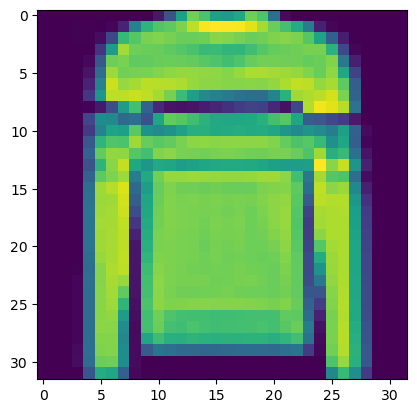

In [11]:
plt.imshow(orig)

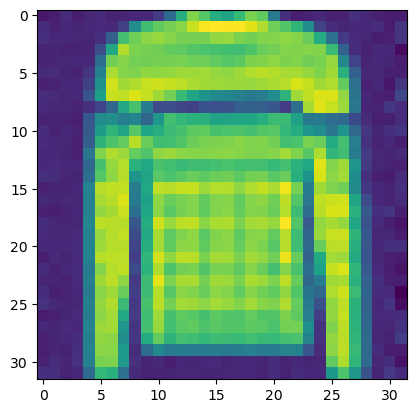

In [12]:
plt.imshow(recIM)

In [13]:
# PSNR of direct backward reconstruction of coefficients without perturbation 
orig_normal = Normalize()(orig)
recIM_norm = Normalize()(recIM)
psnr(orig_normal, recIM_norm, data_range=1.)

21.952022709420625

In [14]:
# MSE of direct reconstruction

np.mean(((orig_normal - np.array(recIM_norm))**2)*0.5)

0.0031898315

In [15]:
prozs = [0.01, 0.2, 0.5, 0.7] 

In [16]:
orig = np.array(orig)

In [17]:
rand_perturb = []

testRK_pert = np.array(testRK)
testRK_pert = testRK_pert.reshape(1,testRK_pert.shape[0])
for proz in prozs:
    
    rand_perturb.append(np.random.rand(1,testRK_pert.shape[1])*(np.max(testRK_pert)-np.min(testRK_pert))*proz)

In [18]:
rand_perturb[0].shape

(1, 784)

In [19]:
orig_perturb = []
for rand_transform in rand_perturb:
    orig_perturb.append(torch.from_numpy(np.add(testRK_pert,rand_transform)).reshape(rand_transform.shape))#.to(device))
    #rec_perturb.append(model(orig_perturb[-1].float()))

In [20]:
# reconstruction from 10% perturbed
#testRK = get_all_thetas(orig)
#testRK = testRK.float()
pert_coeff = torch.tensor(orig_perturb[0]).float()
recIM_pert10 = torch.matmul(X_p.float(), pert_coeff.T).T
recIM_pert10 = recIM_pert10.reshape(32,32)

/tmp/ipykernel_19138/1897946234.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pert_coeff = torch.tensor(orig_perturb[0]).float()


In [21]:
testRK_pert.shape

(1, 784)

In [22]:
#MSE of coefficient perturbnbation
np.mean(((testRK_pert - np.array(pert_coeff))**2)*0.5)

342122.56

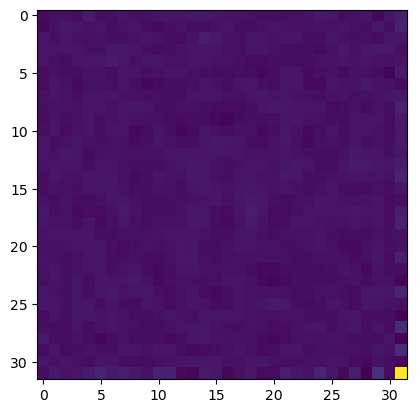

In [23]:
plt.imshow(recIM_pert10)

In [24]:
orig_normal.shape

(32, 32)

In [25]:
# PSNR of direct backward reconstruction of coefficients without perturbation 
orig_normal = Normalize()(orig)
recIM_pert10_norm = Normalize()(recIM_pert10)
psnr(orig_normal, recIM_pert10_norm, data_range=1.)

5.230223097254628

In [26]:
#what is MSE of initial and final images

np.mean(((orig_normal - recIM_pert10_norm)**2)*0.5)

0.14995041